# Methods & Results

In [1]:
install.packages("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
tidymodels_prefer()


### Data Preparation
We loaded `players.csv`, selected only the relevant columns: `Age`, `played_hours`, and `subscribe`. We dropped missing values and converted `subscribe` to a factor for classification.

In [17]:
players <- read_csv("players.csv") |>
  select(Age, played_hours, subscribe) |>
  drop_na() |>
  mutate(subscribe = as_factor(subscribe))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
set.seed(1234)

split <- initial_split(players, prop = 0.8, strata = subscribe)
train <- training(split)
test <- testing(split)

In [19]:
train |> count(subscribe)

subscribe,n
<fct>,<int>
FALSE,41
TRUE,113


### Exploratory Data Analysis (EDA)
**Figure 1** shows age distribution by subscription status. **Figure 2** shows played hours on a log scale, and **Figure 3** shows a scatterplot of Age vs Played Hours.

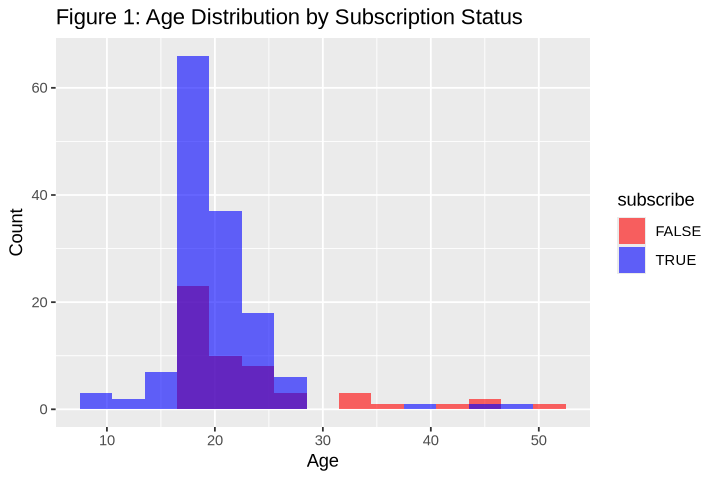

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)

# Age distribution
players |> 
  ggplot(aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 15, alpha = 0.6, position = "identity") +
  scale_fill_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(title = "Figure 1: Age Distribution by Subscription Status", x = "Age", y = "Count")


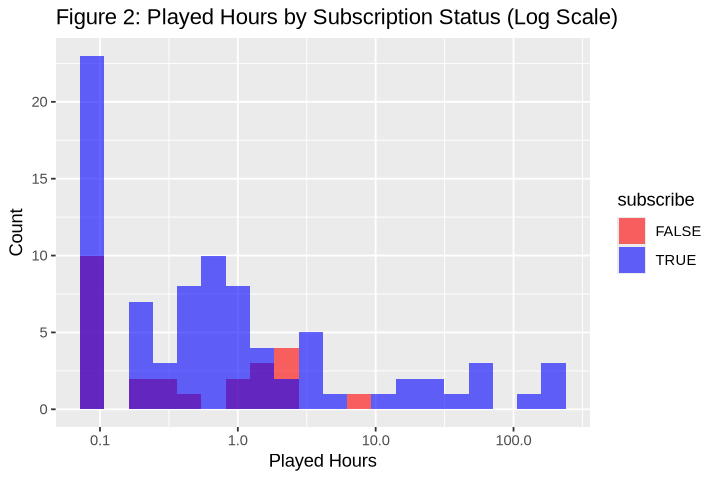

In [21]:
# Played hours (log)
players |> 
  filter(played_hours > 0) |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 20, alpha = 0.6, position = "identity") +
  scale_x_log10() +
  scale_fill_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(title = "Figure 2: Played Hours by Subscription Status (Log Scale)", x = "Played Hours", y = "Count")


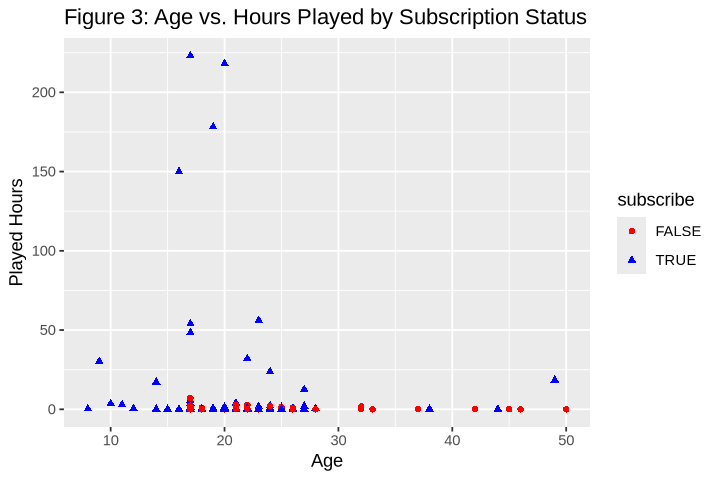

In [22]:
# Scatter plot
players |> 
  ggplot(aes(x = Age, y = played_hours, color = subscribe, shape = subscribe)) +
  geom_point() +
  scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(title = "Figure 3: Age vs. Hours Played by Subscription Status", x = "Age", y = "Played Hours")


### Model Training and Selection
We split the dataset into 80% training and 20% testing. We normalized predictors and performed 5-fold cross-validation to tune K from 1 to 20. The best K is selected based on highest validation accuracy.

In [23]:

recipe_knn <- recipe(subscribe ~ Age + played_hours, data = train) |>
  step_normalize(all_predictors())

knn_spec <- nearest_neighbor(
  mode = "classification",
  neighbors = tune(),
  weight_func = "rectangular"
) |> set_engine("kknn")

knn_wf <- workflow() |>
  add_recipe(recipe_knn) |>
  add_model(knn_spec)

folds <- vfold_cv(train, v = 5, strata = subscribe)

results <- tune_grid(knn_wf, resamples = folds, grid = tibble(neighbors = 1:20))


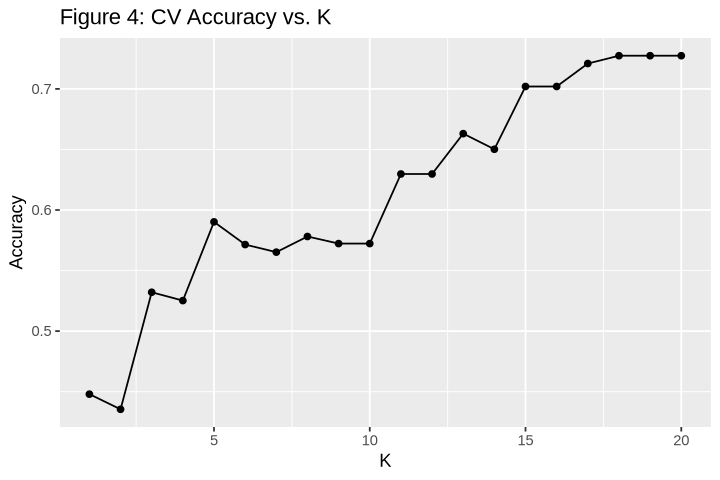

In [24]:
# CV accuracy plot
results |> 
  collect_metrics() |> 
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Figure 4: CV Accuracy vs. K", x = "K", y = "Accuracy")


In [25]:
best_k <- select_best(results, metric = "accuracy")
best_k


neighbors,.config
<int>,<chr>
18,Preprocessor1_Model18


### Model Evaluation
We finalized the workflow with the best K value, trained it on the full training set, and evaluated accuracy and confusion matrix on the test set.

In [26]:
final_wf <- finalize_workflow(knn_wf, best_k)
final_fit <- last_fit(final_wf, split)

collect_metrics(final_fit)


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7250000,Preprocessor1_Model1
roc_auc,binary,0.5658307,Preprocessor1_Model1
brier_class,binary,0.2002315,Preprocessor1_Model1


In [27]:
final_fit |> 
  collect_predictions() |> 
  conf_mat(truth = subscribe, estimate = .pred_class)


          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     11   29

New names:
• `subscribe` -> `subscribe...3`
• `subscribe` -> `subscribe...9`


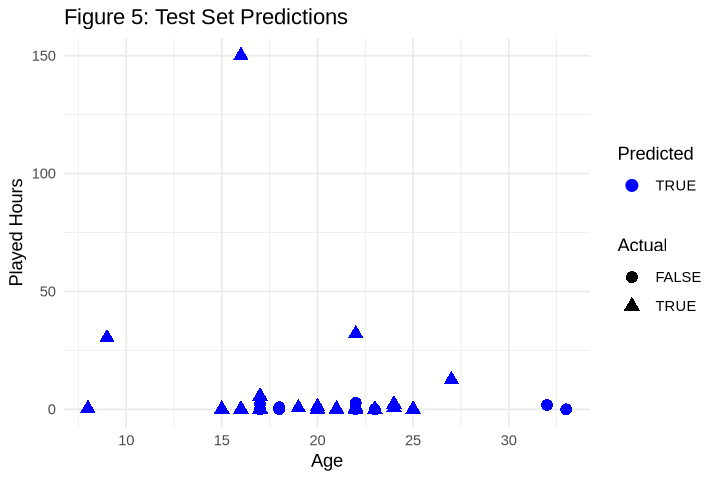

In [28]:

pred_data <- final_fit |> collect_predictions()

test_preds <- bind_cols(test, pred_data) |> 
  rename(actual = subscribe...3, predicted = .pred_class)


ggplot(test_preds, aes(x = Age, y = played_hours, color = predicted, shape = actual)) +
  geom_point(size = 3) +
  scale_color_manual(values = c("TRUE" = "blue", "FALSE" = "red")) +
  labs(
    title = "Figure 5: Test Set Predictions",
    x = "Age",
    y = "Played Hours",
    color = "Predicted",
    shape = "Actual"
  ) +
  theme_minimal()


In Figure 5, color represents the predicted subscription status, while shape represents the actual status. All points are colored blue, indicating that the model predicted "subscribed" (TRUE) for every individual. However, the presence of circular points (actual = FALSE) shows that some predictions were incorrect.